<a href="https://colab.research.google.com/github/Srabontideb/GAN-Enhanced-Gastrointestinal-Disease-Classification/blob/main/GI_disease_CLAHE_and_MSRCR_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless kagglehub tqdm --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ✅ STEP 3: Download Dataset from Kaggle using kagglehub
import kagglehub
import os

dataset_path = kagglehub.dataset_download('yasserhessein/the-kvasir-dataset')
input_path = os.path.join(dataset_path, 'kvasir-dataset-v2')
working_path = '/content/kvasir_temp'
os.makedirs(working_path, exist_ok=True)

class_labels = [
    'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
    'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis'
]

100%|██████████| 2.32G/2.32G [00:27<00:00, 91.8MB/s]


Extracting files...


In [ ]:
# ✅ STEP 4A: CLAHE + Gaussian Only
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_clahe_gaussian(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=1.7, tileGridSize=(5, 5))
    r_eq = clahe.apply(r)
    g_eq = clahe.apply(g)
    b_eq = clahe.apply(b)
    merged = cv2.merge((r_eq, g_eq, b_eq))
    return cv2.GaussianBlur(merged, (5, 5), 0)

In [ ]:
def MSRCR(img, sigma_list=[15, 80, 250], G=5.0, b=25.0, alpha=125.0, beta=46.0):
    img = img.astype(np.float64) + 1.0
    img_retinex = np.zeros_like(img)
    for sigma in sigma_list:
        for i in range(3):
            blurred = cv2.GaussianBlur(img[:, :, i], (0, 0), sigma)
            img_retinex[:, :, i] += np.log10(img[:, :, i]) - np.log10(blurred + 1.0)
    img_retinex /= len(sigma_list)
    intensity = np.sum(img, axis=2) / 3.0
    color_restoration = beta * (
        np.log10(alpha * img) - np.log10(intensity[:, :, np.newaxis] + 1.0)
    )
    msrcr = G * (img_retinex * color_restoration + b)
    msrcr = np.clip((msrcr - np.min(msrcr)) / (np.max(msrcr) - np.min(msrcr)) * 255, 0, 255).astype(np.uint8)
    return msrcr

In [ ]:
# ✅ STEP 5: Visualize CLAHE + Gaussian on One Sample
sample_path = os.path.join(input_path, 'dyed-lifted-polyps')
sample_img_name = os.listdir(sample_path)[1]
sample_img_path = os.path.join(sample_path, sample_img_name)

original_img = cv2.imread(sample_img_path)
clahe_gauss_img = apply_clahe_gaussian(original_img)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clahe_gauss_img)
plt.title("After CLAHE + Gaussian")
plt.axis("off")

plt.tight_layout()
plt.show()

NameError: name 'dataset_path' is not defined

In [ ]:
import signal

def save_on_interrupt(signum, frame):
    print("⏳ Session interrupt detected. Saving files...")
    !cp -r /content/kvasir_temp/* /content/drive/MyDrive/kvasir_outputs
    print("✅ Saved. You can safely reconnect.")

signal.signal(signal.SIGTERM, save_on_interrupt)


In [ ]:
# ✅ STEP 6: Process Images and Save
from tqdm import tqdm
import os

def apply_processing(image_path, output_path):
    img = cv2.imread(image_path)
    if img is None:
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=1.7, tileGridSize=(5,5))
    r_eq = clahe.apply(r)
    g_eq = clahe.apply(g)
    b_eq = clahe.apply(b)
    equalized_image = cv2.merge((r_eq, g_eq, b_eq))
    smoothed_img = cv2.GaussianBlur(equalized_image, (5, 5), 0)
    enhanced_img = MSRCR(smoothed_img)
    final_bgr = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, final_bgr)

for idx, class_name in enumerate(class_labels):
    in_class_path = os.path.join(input_path, class_name)
    out_class_path = os.path.join(working_path, f"{idx:02d}")
    os.makedirs(out_class_path, exist_ok=True)
    for img_file in tqdm(os.listdir(in_class_path), desc=f"Processing {class_name}"):
        in_img_path = os.path.join(in_class_path, img_file)
        out_img_path = os.path.join(out_class_path, img_file)
        apply_processing(in_img_path, out_img_path)

print("✅ All images processed and saved in:", working_path)

NameError: name 'input_path' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/kvasir_temp /content/drive/MyDrive/kvasir_outputs


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/kvasir_temp': No such file or directory


In [ ]:
import os

drive_path = "/content/drive/MyDrive/kvasir_outputs"
if os.path.exists(drive_path):
    print("✅ Found saved images at:", drive_path)
    print("Sample files:", os.listdir(drive_path)[:5])
else:
    print("❌ Output folder not found in Drive.")


❌ Output folder not found in Drive.


In [ ]:
# ✅ STEP 1: Setup & Install Required Libraries
!pip install opencv-python-headless kagglehub tqdm --quiet

In [ ]:
# ✅ STEP 2: Mount Google Drive (For Saving Outputs Permanently)
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ✅ STEP 3: Define Persistent Output Path in Google Drive
working_path = '/content/drive/MyDrive/kvasir_outputs'
os.makedirs(working_path, exist_ok=True)


In [ ]:
# ✅ STEP 4: Download Dataset from Kaggle using kagglehub
import kagglehub

dataset_path = kagglehub.dataset_download('yasserhessein/the-kvasir-dataset')
input_path = os.path.join(dataset_path, 'kvasir-dataset-v2')

class_labels = [
    'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
    'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis'
]


100%|██████████| 2.32G/2.32G [00:30<00:00, 80.7MB/s]

Extracting files...


In [ ]:
# ✅ STEP 5A: CLAHE + Gaussian Only
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_clahe_gaussian(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=1.7, tileGridSize=(5, 5))
    r_eq = clahe.apply(r)
    g_eq = clahe.apply(g)
    b_eq = clahe.apply(b)
    merged = cv2.merge((r_eq, g_eq, b_eq))
    return cv2.GaussianBlur(merged, (5, 5), 0)


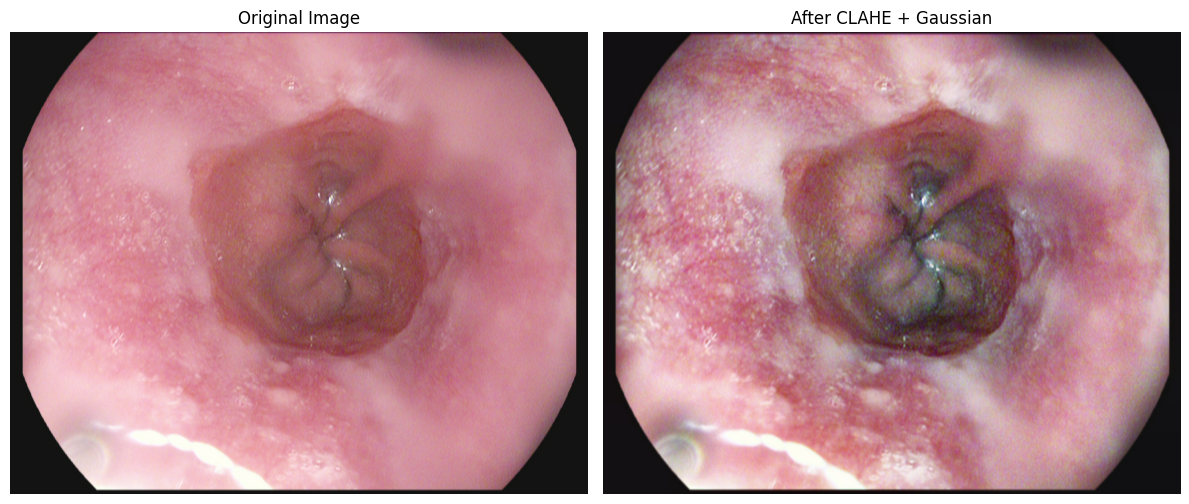

In [ ]:
# ✅ STEP 6: Visualize CLAHE + Gaussian on One Sample
sample_path = os.path.join(input_path, 'esophagitis')
sample_img_name = os.listdir(sample_path)[2]
sample_img_path = os.path.join(sample_path, sample_img_name)

original_img = cv2.imread(sample_img_path)
clahe_gauss_img = apply_clahe_gaussian(original_img)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clahe_gauss_img)
plt.title("After CLAHE + Gaussian")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ✅ STEP 5B: MSRCR Function
def MSRCR(img, sigma_list=[15, 80, 250], G=5.0, b=25.0, alpha=125.0, beta=46.0):
    img = img.astype(np.float64) + 1.0
    img_retinex = np.zeros_like(img)
    for sigma in sigma_list:
        for i in range(3):
            blurred = cv2.GaussianBlur(img[:, :, i], (0, 0), sigma)
            img_retinex[:, :, i] += np.log10(img[:, :, i]) - np.log10(blurred + 1.0)
    img_retinex /= len(sigma_list)
    intensity = np.sum(img, axis=2) / 3.0
    color_restoration = beta * (
        np.log10(alpha * img) - np.log10(intensity[:, :, np.newaxis] + 1.0)
    )
    msrcr = G * (img_retinex * color_restoration + b)
    msrcr = np.clip((msrcr - np.min(msrcr)) / (np.max(msrcr) - np.min(msrcr)) * 255, 0, 255).astype(np.uint8)
    return msrcr

In [ ]:
import os

drive_root = '/content/drive/MyDrive'
print("Root contents:", os.listdir(drive_root))


Root contents: ['Colab Notebooks', 'srabonti', '1803163 (1).cpp', 'Management Assignment (Responses).gsheet', 'Class', 'Idea_contest.pptx', '1803163.cpp', '2-1 semester- all', 'Certificate', 'lfr.ai', 'E-commerce website', 'css', '1803163.asm', 'ID Card', '1803163_DSP_lab', 'song 01.mp4', 'ER+diagram(Department Relationships).drawio', 'Untitled Diagram (3).drawio', 'Untitled Diagram (2).drawio', 'Untitled Diagram (1).drawio', 'Untitled Diagram.drawio', 'HR_Schema.drawio', 'ER_model_system.drawio', 'Data_flow_diagram.drawio', 'Existing_DFD.drawio', 'Proposed dfd.drawio', 'Copy of Lab Test Syllabus of CSE 4102 (18 Series) (1).gdoc', '1803163', 'Copy of Lab Test Syllabus of CSE 4102 (18 Series).gdoc', 'output.gsheet', '1803163.zip', 'inbound1352501412346342138.pdf', 'inbound4133263682077295447.pdf', 'inbound8664260997736664543.pdf', 'iris.csv', '1803163.pdf', 'Important documents', 'Classroom', 'NeW IDCARD', 'My Resume (2).pdf', 'inbound1055853341213650355.pdf', 'inbound428806324480255100

In [ ]:
output_folder = '/content/drive/MyDrive/kvasir_outputs'
print("Output folder contents:", os.listdir(output_folder))


Output folder contents: ['00', '01', '02', '03', '04', '05']


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/kvasir_outputs'))


['00', '01', '02', '03', '04', '05']


# **Full dataset processing**

In [ ]:
import os
import cv2
from tqdm import tqdm

# Set input and output paths
class_name = 'esophagitis'  # Choose one class to process
input_class_path = os.path.join(input_path, class_name)
working_path = '/content/drive/MyDrive/kvasir_outputs'
output_class_path = os.path.join(working_path, '02')  # Use '00' or any folder name you like
os.makedirs(output_class_path, exist_ok=True)

def apply_processing(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read {image_path}")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clahe_img = apply_clahe_gaussian(img_rgb)  # Your CLAHE + Gaussian function
    msrcr_img = MSRCR(clahe_img)               # Your MSRCR function
    return cv2.cvtColor(msrcr_img, cv2.COLOR_RGB2BGR)

# Process all images in the chosen class folder
for image_name in tqdm(os.listdir(input_class_path), desc=f"Processing {class_name}"):
    input_img_path = os.path.join(input_class_path, image_name)
    processed_image = apply_processing(input_img_path)
    if processed_image is not None:
        output_path = os.path.join(output_class_path, image_name)
        cv2.imwrite(output_path, processed_image)
    else:
        print(f"Skipping {input_img_path} due to processing error.")


Processing esophagitis: 100%|██████████| 1000/1000 [6:21:19<00:00, 22.88s/it]


In [ ]:
import os
import cv2
from tqdm import tqdm

# Set input and output paths
class_name = 'normal-cecum'  # Choose one class to process
input_class_path = os.path.join(input_path, class_name)
working_path = '/content/drive/MyDrive/kvasir_outputs'
output_class_path = os.path.join(working_path, '03')  # Use '00' or any folder name you like
os.makedirs(output_class_path, exist_ok=True)

def apply_processing(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read {image_path}")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clahe_img = apply_clahe_gaussian(img_rgb)  # Your CLAHE + Gaussian function
    msrcr_img = MSRCR(clahe_img)               # Your MSRCR function
    return cv2.cvtColor(msrcr_img, cv2.COLOR_RGB2BGR)

# Process all images in the chosen class folder
for image_name in tqdm(os.listdir(input_class_path), desc=f"Processing {class_name}"):
    input_img_path = os.path.join(input_class_path, image_name)
    processed_image = apply_processing(input_img_path)
    if processed_image is not None:
        output_path = os.path.join(output_class_path, image_name)
        cv2.imwrite(output_path, processed_image)
    else:
        print(f"Skipping {input_img_path} due to processing error.")


Processing normal-cecum: 100%|██████████| 1000/1000 [1:27:19<00:00,  5.24s/it]


In [ ]:
import os
import cv2
from tqdm import tqdm

# Set input and output paths
class_name = 'normal-pylorus'  # Choose one class to process
input_class_path = os.path.join(input_path, class_name)
working_path = '/content/drive/MyDrive/kvasir_outputs'
output_class_path = os.path.join(working_path, '04')  # Use '00' or any folder name you like
os.makedirs(output_class_path, exist_ok=True)

def apply_processing(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read {image_path}")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clahe_img = apply_clahe_gaussian(img_rgb)  # Your CLAHE + Gaussian function
    msrcr_img = MSRCR(clahe_img)               # Your MSRCR function
    return cv2.cvtColor(msrcr_img, cv2.COLOR_RGB2BGR)

# Process all images in the chosen class folder
for image_name in tqdm(os.listdir(input_class_path), desc=f"Processing {class_name}"):
    input_img_path = os.path.join(input_class_path, image_name)
    processed_image = apply_processing(input_img_path)
    if processed_image is not None:
        output_path = os.path.join(output_class_path, image_name)
        cv2.imwrite(output_path, processed_image)
    else:
        print(f"Skipping {input_img_path} due to processing error.")

Processing normal-pylorus: 100%|██████████| 1000/1000 [6:41:10<00:00, 24.07s/it]


In [ ]:
import os
import cv2
from tqdm import tqdm

# Set input and output paths
class_name = 'normal-z-line'  # Choose one class to process
input_class_path = os.path.join(input_path, class_name)
working_path = '/content/drive/MyDrive/kvasir_outputs'
output_class_path = os.path.join(working_path, '05')  # Use '00' or any folder name you like
os.makedirs(output_class_path, exist_ok=True)

def apply_processing(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read {image_path}")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clahe_img = apply_clahe_gaussian(img_rgb)  # Your CLAHE + Gaussian function
    msrcr_img = MSRCR(clahe_img)               # Your MSRCR function
    return cv2.cvtColor(msrcr_img, cv2.COLOR_RGB2BGR)

# Process all images in the chosen class folder
for image_name in tqdm(os.listdir(input_class_path), desc=f"Processing {class_name}"):
    input_img_path = os.path.join(input_class_path, image_name)
    processed_image = apply_processing(input_img_path)
    if processed_image is not None:
        output_path = os.path.join(output_class_path, image_name)
        cv2.imwrite(output_path, processed_image)
    else:
        print(f"Skipping {input_img_path} due to processing error.")

Processing normal-z-line: 100%|██████████| 1000/1000 [5:03:31<00:00, 18.21s/it]


In [ ]:
import os
import cv2
from tqdm import tqdm

# Set input and output paths
class_name = 'polyps'  # Choose one class to process
input_class_path = os.path.join(input_path, class_name)
working_path = '/content/drive/MyDrive/kvasir_outputs'
output_class_path = os.path.join(working_path, '06')  # Use '00' or any folder name you like
os.makedirs(output_class_path, exist_ok=True)

def apply_processing(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read {image_path}")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clahe_img = apply_clahe_gaussian(img_rgb)  # Your CLAHE + Gaussian function
    msrcr_img = MSRCR(clahe_img)               # Your MSRCR function
    return cv2.cvtColor(msrcr_img, cv2.COLOR_RGB2BGR)

# Process all images in the chosen class folder
for image_name in tqdm(os.listdir(input_class_path), desc=f"Processing {class_name}"):
    input_img_path = os.path.join(input_class_path, image_name)
    processed_image = apply_processing(input_img_path)
    if processed_image is not None:
        output_path = os.path.join(output_class_path, image_name)
        cv2.imwrite(output_path, processed_image)
    else:
        print(f"Skipping {input_img_path} due to processing error.")

Processing polyps: 100%|██████████| 1000/1000 [1:36:10<00:00,  5.77s/it]


In [ ]:
import os
import cv2
from tqdm import tqdm

# Set input and output paths
class_name = 'ulcerative-colitis'  # Choose one class to process
input_class_path = os.path.join(input_path, class_name)
working_path = '/content/drive/MyDrive/kvasir_outputs'
output_class_path = os.path.join(working_path, '07')  # Use '00' or any folder name you like
os.makedirs(output_class_path, exist_ok=True)

def apply_processing(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read {image_path}")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clahe_img = apply_clahe_gaussian(img_rgb)  # Your CLAHE + Gaussian function
    msrcr_img = MSRCR(clahe_img)               # Your MSRCR function
    return cv2.cvtColor(msrcr_img, cv2.COLOR_RGB2BGR)

# Process all images in the chosen class folder
for image_name in tqdm(os.listdir(input_class_path), desc=f"Processing {class_name}"):
    input_img_path = os.path.join(input_class_path, image_name)
    processed_image = apply_processing(input_img_path)
    if processed_image is not None:
        output_path = os.path.join(output_class_path, image_name)
        cv2.imwrite(output_path, processed_image)
    else:
        print(f"Skipping {input_img_path} due to processing error.")

Processing ulcerative-colitis: 100%|██████████| 1000/1000 [1:35:40<00:00,  5.74s/it]
